# Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [4]:
PATH = "data/demand-forecasting/"

# Helper Functions

In [5]:
# custom evaluation metric
def SMAPE(y_pred, dtrain):
    y_true = dtrain.get_label()
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 'SMAPE', np.nanmean(diff)

In [6]:
def smape2(y_pred, y_true):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)

In [7]:
def print_scores(pred,label):
    rmse = np.sqrt(mean_squared_error(pred,label))
    mae = mean_absolute_error(pred,label)
    smape_score = smape2(pred,label)
    
    print('RMSE: ' + str(rmse))
    print('MAE: ' + str(mae))
    print('SMAPE: ' + str(smape_score))

In [8]:
def plot_learning_curve(results,trn,val,metric):
    train_errors = results[trn][metric]
    validation_errors = results[val][metric]
    df = pd.DataFrame([train_errors, validation_errors]).T
    df.columns = ['Training', 'Validation']
    df.index.name = 'Boosting Round'
    ax = df.plot(title="XGBoost learning curves",figsize=(12,5))
    ax.set_ylabel(metric)

# Pre-Process Data

In [9]:
train = pd.read_csv(f'{PATH}train.csv', parse_dates=['date'])
test = pd.read_csv(f'{PATH}test.csv', parse_dates=['date'], index_col='id')

In [10]:
train['y'] = train['date'].dt.year
train['m'] = train['date'].dt.month
train['d'] = train['date'].dt.day
train['dw'] = train['date'].dt.dayofweek
train['dy'] = train['date'].dt.dayofyear
train.drop('date', axis=1, inplace=True)

sales = train.pop('sales')

In [11]:
test['y'] = test['date'].dt.year
test['m'] = test['date'].dt.month
test['d'] = test['date'].dt.day
test['dw'] = test['date'].dt.dayofweek
test['dy'] = test['date'].dt.dayofyear
test.drop('date', axis=1, inplace=True)

# Split Training-Validation Data

In [12]:
train.shape, sales.shape, test.shape

((913000, 7), (913000,), (45000, 7))

In [13]:
# closest same period (diff year) as test set
X_val = train.loc[(train.y==2017) & ((train.m==10) | (train.m==11) | (train.m==12))].copy() 
y_val = sales[X_val.index].copy()

X_train = train.drop(X_val.index).copy()
y_train = sales.drop(X_val.index).copy()

In [14]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((867000, 7), (867000,), (46000, 7), (46000,))

In [15]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
print()

# XGBoost API

In [16]:
DM_train = xgb.DMatrix(data=X_train, label=y_train)
DM_val = xgb.DMatrix(data=X_val, label=y_val)
DM_test = xgb.DMatrix(data=test)

In [17]:
evals_result = {}
watchtlist_trn = "training"
watchtlist_val = "validation"
watchlist = [(DM_train, watchtlist_trn), (DM_val, watchtlist_val)]

In [18]:
params_native_simple = {
    'objective': 'reg:linear',  # 'reg:linear'
    'booster':'gbtree',         # 'gbtree'
    'silent': 1,                # 0   
    'eta': 0.1,                 # 0.3 alias learning_rate
    'gamma': 0,                 # 0
    'max-depth': 3,             # 6
    'min_child_weight': 1,      # 1
    'max_delta_step': 0,        # 0
    'subsample': 1,             # 1
    'colsample_bytree': 1,      # 1
    'colsample_bylevel': 1,     # 1
    'lambda': 1,                # 1  
    'alpha': 0,                 # 0
    'scale_pos_weight': 1,      # 1
    'base_score': 0.5,          # 0.5
    'eval_metric':'rmse',       # 'rmse' for regression
    'seed': 42                  # 0 
}

In [19]:
%%time
xgb_native = xgb.train(params=params_native_simple, 
                              dtrain=DM_train,
                              num_boost_round=5001,
                              evals=watchlist,
                              early_stopping_rounds=20,
                              evals_result=evals_result,
                              verbose_eval=50)

[0]	training-rmse:54.2027	validation-rmse:56.1649
Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.

Will train until validation-rmse hasn't improved in 20 rounds.
[50]	training-rmse:13.2316	validation-rmse:13.8439
[100]	training-rmse:9.13504	validation-rmse:9.67734
[150]	training-rmse:8.26563	validation-rmse:8.83967
[200]	training-rmse:7.88388	validation-rmse:8.49632
[250]	training-rmse:7.68541	validation-rmse:8.29289
[300]	training-rmse:7.56807	validation-rmse:8.17582
[350]	training-rmse:7.47846	validation-rmse:8.097
[400]	training-rmse:7.42172	validation-rmse:8.02718
[450]	training-rmse:7.37787	validation-rmse:7.98309
[500]	training-rmse:7.34747	validation-rmse:7.95146
[550]	training-rmse:7.31829	validation-rmse:7.92174
[600]	training-rmse:7.30427	validation-rmse:7.91137
[650]	training-rmse:7.28762	validation-rmse:7.89954
[700]	training-rmse:7.27298	validation-rmse:7.88365
[750]	training-rmse:7.25936	validation-rmse:7.87582
[800]	training-rms

In [20]:
print("Best iteration: {}".format(xgb_native.best_iteration))
print("Best number of trees limit: {}".format(xgb_native.best_ntree_limit))
print("Best RMSE score: {}".format(xgb_native.best_score))

Best iteration: 851
Best number of trees limit: 852
Best RMSE score: 7.862053


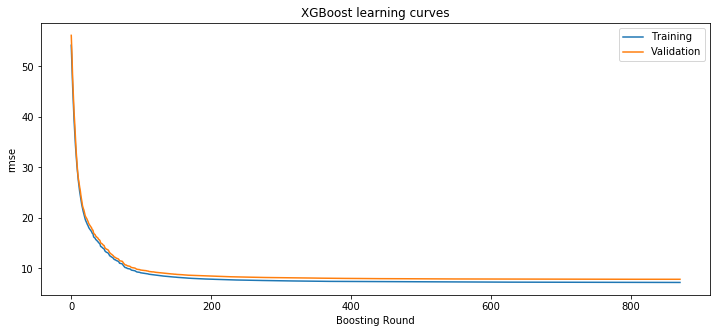

In [21]:
plot_learning_curve(evals_result, watchtlist_trn, watchtlist_val, 'rmse')

# Scikit Learn API

In [22]:
params_sklearn_simple = {
    'objective': 'reg:linear',  # 'reg:linear'
    'booster':'gbtree',         # 'gbtree'
    'silent': True,             # True
    'max-depth': 3,             # 3
    'learning_rate': 0.1,       # 0.1
    'n_estimators': 5001,       # 200
    'n_jobs': 4,                # 1 (replaces nthread)
    'gamma': 0,                 # 0
    'min_child_weight': 1,      # 1
    'max_delta_step': 0,        # 0
    'subsample': 1,             # 1
    'colsample_bytree': 1,      # 1
    'colsample_bylevel': 1,     # 1
    'reg_alpha': 0,             # 0
    'reg_lambda': 1,            # 1
    'scale_pos_weight': 1,      # 1
    'base_score': 0.5,          # 0.5
    'random_state': 42,         # 0 (replaces seed) 
}

In [23]:
xgb_sk = xgb.XGBRegressor(**params_sklearn_simple)

In [24]:
%%time
xgb_sk = xgb_sk.fit(X_train, y_train,
                                  eval_set=[(X_train, y_train),(X_val, y_val)],
                                  eval_metric='rmse', 
                                  verbose=50,
                                  early_stopping_rounds=20)   

[0]	validation_0-rmse:54.3844	validation_1-rmse:56.1363
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[50]	validation_0-rmse:19.4849	validation_1-rmse:20.0717
[100]	validation_0-rmse:15.9126	validation_1-rmse:16.6876
[150]	validation_0-rmse:12.8873	validation_1-rmse:13.3497
[200]	validation_0-rmse:11.3948	validation_1-rmse:11.7167
[250]	validation_0-rmse:10.659	validation_1-rmse:10.8728
[300]	validation_0-rmse:10.1848	validation_1-rmse:10.3628
[350]	validation_0-rmse:9.86631	validation_1-rmse:9.98598
[400]	validation_0-rmse:9.67135	validation_1-rmse:9.77451
[450]	validation_0-rmse:9.54284	validation_1-rmse:9.6318
[500]	validation_0-rmse:9.44738	validation_1-rmse:9.53274
[550]	validation_0-rmse:9.36734	validation_1-rmse:9.46242
[600]	validation_0-rmse:9.28871	validation_1-rmse:9.3947
[650]	validation_0-rmse:9.22934	validation_1-rmse:9.32213
[700]	validation_0-rmse:9.16537	val

In [25]:
print("Best iteration: {}".format(xgb_sk.best_iteration))
print("Best number of trees limit: {}".format(xgb_sk.best_ntree_limit))
print("Best RMSE score: {}".format(xgb_sk.best_score))

Best iteration: 1857
Best number of trees limit: 1858
Best RMSE score: 8.668887


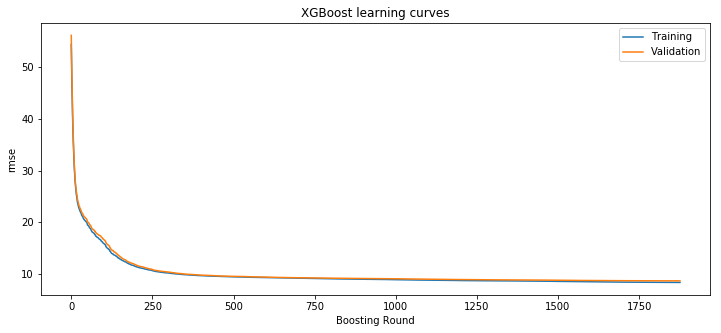

In [26]:
plot_learning_curve(xgb_sk.evals_result(), 'validation_0', 'validation_1', 'rmse')

# Comparisons

In [27]:
print("Native")
print("Best iteration: {}".format(xgb_native.best_iteration))
print("Best number of trees limit: {}".format(xgb_native.best_ntree_limit))
print("Best RMSE score: {}".format(xgb_native.best_score))

print("\nSKLearn")
print("Best iteration: {}".format(xgb_sk.best_iteration))
print("Best number of trees limit: {}".format(xgb_sk.best_ntree_limit))
print("Best RMSE score: {}".format(xgb_sk.best_score))

Native
Best iteration: 851
Best number of trees limit: 852
Best RMSE score: 7.862053

SKLearn
Best iteration: 1857
Best number of trees limit: 1858
Best RMSE score: 8.668887


In [28]:
print("Training score Native")
pred_train = xgb_native.predict(DM_train)
print_scores(pred_train, y_train)

print("\nTraining score SKLearn")
pred_train = xgb_sk.predict(X_train)
print_scores(pred_train, y_train)

Training score Native
RMSE: 7.2359376085156155
MAE: 5.571136870407316
SMAPE: 12.597623445040107

Training score SKLearn
RMSE: 8.362823017668001
MAE: 6.448160136094418
SMAPE: 15.760075952351887


In [29]:
print("Validation score Native")
pred_val = xgb_native.predict(DM_val)
print_scores(pred_val, y_val)

print("\nValidation score SKLearn")
pred_val = xgb_sk.predict(X_val)
print_scores(pred_val, y_val)

Validation score Native
RMSE: 7.8621608592696335
MAE: 6.085678606136986
SMAPE: 12.804424734422618

Validation score SKLearn
RMSE: 8.6692505166153
MAE: 6.721057647669445
SMAPE: 15.017970962883163
